In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from unyt import yr, Myr, kpc, arcsec, nJy, Mpc, Msun, erg, s, Hz, kelvin, angstrom
%pip install schwimmbad
import schwimmbad
import h5py

from synthesizer.grid import Grid
from synthesizer.load_data.load_camels import load_CAMELS_SwiftEAGLE_subfind
from synthesizer.sed import Sed
from synthesizer.filters import Filter, FilterCollection
from synthesizer.sed import combine_list_of_seds
from synthesizer.emission_models import (
    IncidentEmission,
)

from synthesizer.conversions import lnu_to_absolute_mag, fnu_to_apparent_mag, fnu_to_lnu

Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_8037/755533471.py:12: FutureWarning: The filters module has been moved to the instruments module. Please update your imports synthesizer.filters -> synthesizer.instruments
  from synthesizer.filters import Filter, FilterCollection


In [2]:
# get grid for all galaxies
# gives grid of metalicity and age which is used to map on our camels galaxies
grid_name = "bc03_chabrier03-0.1,100.hdf5"
#grid_name = "bc03-2016-Miles_chabrier-0.1,100.hdf5" # try old grid, LF looks weird?!
grid_dir = "/home/jovyan/"
grid = Grid(grid_name, grid_dir=grid_dir, read_lines=False)

In [3]:
# get gals

CV_X = 'CV_20'
_dir = '/home/jovyan/Data/Sims/Swift-EAGLE/L25n256/CV/' + CV_X
group_dir = '/home/jovyan/Data/FOF_Subfind/Swift-EAGLE/L25n256/CV/' + CV_X


In [4]:

gals_074 = load_CAMELS_SwiftEAGLE_subfind(
    _dir='/home/jovyan/Data/Sims/Swift-EAGLE/L25n256/CV/' + CV_X,
    snap_name="snapshot_074.hdf5",
    group_name="groups_074.hdf5",
    group_dir='/home/jovyan/Data/FOF_Subfind/Swift-EAGLE/L25n256/CV/' + CV_X
)



In [5]:

print('Number of Galaxies in snap_074', len(gals_074))

cat_074 = group_dir+'/groups_074.hdf5'
# open file
f = h5py.File(cat_074, 'r')

# read different attributes of the header
boxSize_074 = f['Header'].attrs[u'BoxSize']/1e3 #Mpc/h
redshift_074 = f['Header'].attrs[u'Redshift']
print('BoxSize: ', boxSize_074)
print('redshift: ', redshift_074)

Number of Galaxies in snap_074 1798
BoxSize:  25.0
redshift:  107.26349599556876


In [6]:
import h5py

# Open the HDF5 file for snapshot 074
cat_074 = group_dir + '/groups_074.hdf5'
f = h5py.File(cat_074, 'r')

# Read different attributes of the header
boxSize_074 = f['Header'].attrs[u'BoxSize']/1e3  # Mpc/h
redshift_074 = f['Header'].attrs[u'Redshift']    # You said this seems wrong
scale_factor_074 = 0.681#f['Header'].attrs[u'Scale-factor']  # Let's grab the scale factor

# Compute the redshift from the scale factor
redshift_computed_074 = (1 / scale_factor_074) - 1

# Print the information
print('BoxSize: ', boxSize_074)
print('Redshift (from file): ', redshift_074)
print('Scale factor: ', scale_factor_074)
print('Computed Redshift (from scale factor): ', redshift_computed_074)


BoxSize:  25.0
Redshift (from file):  107.26349599556876
Scale factor:  0.681
Computed Redshift (from scale factor):  0.46842878120411147


In [7]:
gal =gals_074[0]
gal.gas.nparticles

195409

In [8]:
# Filter galaxies to only include those with 100 or more star particles
## NEED TO ADD FILTER TO GET RID OF ANY GALAXIES WITH LESS THAN 100 star Particles!! This is the resolution limit!!
# Chris: when you load your galaxies in could you do a filter for those with at least 100 star particles? that's the resolution limit

gals_074 = [gal for gal in gals_074 if len(gal.stars.ages) >= 100]  # this shouldnt be here?! donesnt make sense
gals_074 = [gal for gal in gals_074 if gal.stars.nstars >= 100]
#gals_074 = [gal for gal in gals_074 if gal.gas.nparticles >= 100]

# Ensure that the gas component exists and has 100 or more particles
gals_074 = [gal for gal in gals_074 if gal.gas is not None and hasattr(gal.gas, 'nparticles') and gal.gas.nparticles >= 100]

In [9]:
incident = IncidentEmission(grid)
little_h =  0.6711

spec_list = []
# Lets work with z=0 so gals_025
for i in gals_074:
    gal = i
    # get_spectra_incident An Sed object containing the stellar spectra
    spec = gal.stars.get_spectra(incident)
    spec.get_fnu0()
    spec_list.append(spec)


In [10]:
# combine
seds = combine_list_of_seds(spec_list)
seds

In [11]:
seds.lnu  # get luminosity
# A typical value for the spectral luminosity density of a galaxy is around 28 erg/(Hz*s)

unyt_array([[3.00963078e+23, 3.51151039e+23, 3.90298646e+23, ...,
        1.34643004e+27, 9.87755283e+26, 7.54999276e+26],
       [5.69211431e+22, 7.02739101e+22, 8.18185486e+22, ...,
        7.18529373e+26, 5.27325342e+26, 4.03194176e+26],
       [3.00971718e+22, 3.74125892e+22, 4.36460724e+22, ...,
        4.07569815e+26, 2.99079358e+26, 2.28659417e+26],
       ...,
       [6.62928947e+21, 7.44314410e+21, 8.00185571e+21, ...,
        9.54750093e+24, 6.99711275e+24, 5.34393137e+24],
       [3.76941629e+21, 4.45715857e+21, 4.97516317e+21, ...,
        2.72963036e+25, 2.00202992e+25, 1.53025623e+25],
       [1.33795969e+21, 1.66878678e+21, 1.95170697e+21, ...,
        8.95826254e+24, 6.56741775e+24, 5.01706479e+24]], 'erg/(Hz*s)')

In [12]:
# Need to use the grid lam, dont need to define wavelengths here: see codes here: http://svo2.cab.inta-csic.es/theory/fps/index.php?id=Swift/UVOT.UVM2&&mode=browse&gname=Swift&gname2=UVOT#filter
# need to use transmission NOT area
# Get for XMM
fil_uvm2_XMM = Filter("XMM/OM.UVM2_filter", new_lam=grid.lam)

# now get for UVOT
fil_uvm2_UVOT = Filter("Swift/UVOT.UVM2_fil", new_lam=grid.lam) # changed from new_lam=lams_uvot to grid.lam and get 0 transmission, but warning sign is back

# what is a top hat filter?
filt1 = Filter("top_hat/filter.1", lam_min=1400*angstrom, lam_max=1600*angstrom, new_lam=grid.lam)

# 0 = TopHat, 1 = XMM, 2= Swift
filt_lst = [filt1, fil_uvm2_XMM, fil_uvm2_UVOT]

# get filters in combined array to apply to all galaxies
combined_filters = FilterCollection(
    filters=filt_lst, new_lam=grid.lam
)


In [13]:
combined_filters.filters

{'top_hat/filter.1': <synthesizer.instruments.filters.Filter at 0x7f1512891a60>,
 'XMM/OM.UVM2_filter': <synthesizer.instruments.filters.Filter at 0x7f1545921700>,
 'Swift/UVOT.UVM2_fil': <synthesizer.instruments.filters.Filter at 0x7f1545921400>}

In [14]:
seds.photo_lnu

In [15]:
phot = seds.get_photo_lnu(combined_filters, verbose=True) 
print(phot)
# phot_mags = [lnu_to_absolute_mag(spec.photo_lnu[f] for f in combined_filters]

--------------------------------------------------------------
|                  PHOTOMETRY (LUMINOSITY)                   |
|--------------------------------------|---------------------|
|  top_hat/filter.1 (λ = 1.50e+03 Å)   | 7.95e+30 erg/(Hz*s) |
|--------------------------------------|---------------------|
| XMM/OM.UVM2_filter (λ = 2.28e+03 Å)  | 8.79e+30 erg/(Hz*s) |
|--------------------------------------|---------------------|
| Swift/UVOT.UVM2_fil (λ = 2.25e+03 Å) | 8.80e+30 erg/(Hz*s) |
--------------------------------------------------------------



In [16]:
abs_mags = [lnu_to_absolute_mag(phot[f]) for f in combined_filters.filters]
#print(abs_mags)


# check 
from astropy.cosmology import Planck18    # You can choose other cosmologies if needed

def apparent_magnitude_from_absolute(redshift, absolute_magnitude):
    # Get the luminosity distance for the given redshift
    # Distnaces are in parsecs
    d_L_pc = Planck18.luminosity_distance(redshift).to('pc').value
    
    # Calculate the apparent magnitude using the distance modulus formula
    apparent_mag = absolute_magnitude - 5 + (5 * np.log10(d_L_pc))
    
    return apparent_mag

ap_test = apparent_magnitude_from_absolute(redshift_074, abs_mags)
ap_test[1] # 1 is XMM-OM


Absolute magnitude is defined to be the apparent magnitude an object would have if it were located at a distance of 10 parsecs.
In astronomy, absolute magnitude (M) is a measure of the luminosity of a celestial object on an inverse logarithmic astronomical magnitude scale.

In [17]:
abs_mag_th = abs_mags[0]

In [18]:
# next steps, get luminosity function for these magnitudes
# co-moving volume: BoxSize_025 and redshift:
little_h =  0.6711
Vphys = (boxSize_074/little_h )**3
Vcom = Vphys * ((1+redshift_computed_074)**3)
print(Vcom)


163688.04954998737


In [19]:
# Alternative method for LF:
# try this method again, but using AB mag instead of mass, and suply your own bins (up to -17, say)
def calc_df(ab_mag, volume, massBinLimits):

# OG:        hist, dummy = np.histogram(np.log10(mstar), bins = massBinLimits)
        hist, dummy = np.histogram(ab_mag, bins = massBinLimits)
        hist = np.float64(hist)
        phi = (hist / volume) / (massBinLimits[1] - massBinLimits[0])

        phi_sigma = (np.sqrt(hist) / volume) /\
                    (massBinLimits[1] - massBinLimits[0]) # Poisson errors

        return phi, phi_sigma, hist

In [20]:
# Define the bin edges for AB magnitudes
# Here, let's define bins from -25 to -17 in steps of 0.5 magnitude
massBinLimits = np.arange(-22, -16, 0.5)

phi, phi_sigma, hist = calc_df(abs_mag_th, Vcom, massBinLimits)

In [21]:
# Define output file path
output_dir_074 = "/home/jovyan/camels/CV_set/CV_outputs/LFs/Swift-EAGLE/"
output_file = f"{output_dir_074}{CV_X}.txt"

# Write the data to the text file
with open(output_file, 'w') as txtfile:
    # Write phi values
    txtfile.write("phi\n")
    for value in phi:
        txtfile.write(f"{value}\n")

    # Write phi_sigma values
    txtfile.write("phi_sigma\n")
    for value in phi_sigma:
        txtfile.write(f"{value}\n")

    # Write hist values
    txtfile.write("hist\n")
    for value in hist:
        txtfile.write(f"{value}\n")

    # Write massBinLimits values
    txtfile.write("massBinLimits\n")
    for value in massBinLimits:
        txtfile.write(f"{value}\n")

print(f'Written out: {output_file}')

Written out: /home/jovyan/camels/CV_set/CV_outputs/LFs/Swift-EAGLE/CV_20.txt


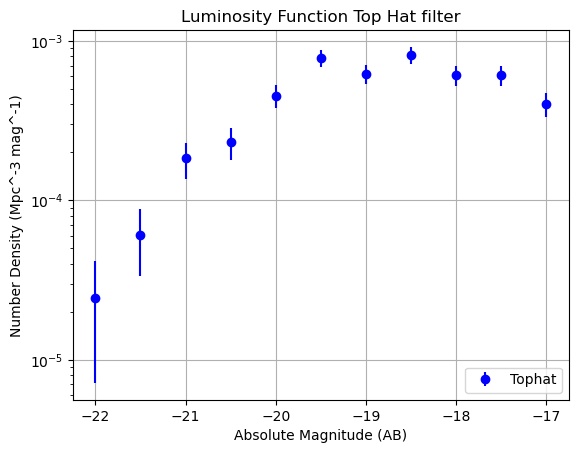

In [22]:

label_025 = 'z = ', redshift_computed_074
label_th = 'Tophat'

# Plot the luminosity function
plt.errorbar(massBinLimits[:-1], phi, yerr=phi_sigma, fmt='o', color='blue', label=label_th)

plt.xlabel('Absolute Magnitude (AB)')
plt.ylabel('Number Density (Mpc^-3 mag^-1)')
plt.yscale('log')
plt.legend(loc='lower right')


plt.title('Luminosity Function Top Hat filter')
plt.grid(True)
plt.show()